# Integration of *pyforce* with *pyDMD* for Dynamic Mode Decomposition (DMD)

This notebook demostrates how to use *pyforce* in combination with the *pyDMD* library to perform Dynamic Mode Decomposition (DMD) analysis on time-dependent data. DMD is a powerful technique for extracting dynamic features from complex systems and it can be combined with *pyforce* to efficient compression and importing of datasets.

In order to run this notebook, please make sure you have *pyDMD* installed in your Python environment. You can install it via pip:

```bash
pip install pydmd
```

The data for this tutorial comes from an OpenFOAM tutorial (com version 2012) for *pimpleFoam* in laminar condition, called [cylinder2D](https://gitlab.com/openfoam/openfoam/-/tree/maintenance-v2012/tutorials/incompressible/pimpleFoam/laminar/cylinder2D?ref_type=heads).

As mentioned in the basic tutorials, the *pyforce* package comes with the `ReadFromOF` class, which allows users to easily import simulation data from OpenFOAM cases. This class must be initialized with the path to the OpenFOAM case folder.

In [20]:
from pyforce.tools.write_read import ReadFromOF
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

io_data = ReadFromOF('../Datasets/LaminarFlowCyl_OF2012/', 
                    skip_zero_time=True # optional
                    )

# Import the mesh information
grid = io_data.mesh()

The variables to import are the pressure (scalar field) and the velocity (vector field). The snapshots can be loaded using `pyvista` (default) or `fluidfoam` libraries: the latter is more efficient for large datasets, but it only supports cell data. The method `import_field` can be used to load the data from the OpenFOAM case and returns the snapshots as a `FunctionsList` object, including a vector with the time instances (from the OpenFOAM directories).

In [21]:
import numpy as np

var_names = ['p', 'U']

dataset = dict()

for field in var_names:

    print('Importing '+field+f' using pyvista')
    dataset[field], times = io_data.import_field(field,
                                              use_fluidfoam=False, verbose=False # optional
                                              )

Importing p using pyvista
Importing U using pyvista


Let us extract the first 80\% of the snapshots as training data for the DMD models.

In [22]:
Nt = len(dataset[var_names[0]])
assert all(len(dataset[var]) == Nt for var in var_names), "Mismatch in number of snapshots among variables."
train_cut = int(0.80 * Nt)

train_snaps = {var: dataset[var][:train_cut] for var in var_names}
train_times = times[:train_cut]

print(f'Training on {train_cut} snapshots out of {Nt} total snapshots.')

Training on 200 snapshots out of 250 total snapshots.


Let us define the plotter class.

In [23]:
from matplotlib import patches, cm, pyplot as plt
from scipy.interpolate import griddata

class PlotFlowCyl:
    def __init__(self, grid, center = (0,0), radius = 0.05, gdim=3):
        self.nodes = grid.cell_centers().points

        self.width = np.max(self.nodes[:,0]) - np.min(self.nodes[:,0])
        self.height = np.max(self.nodes[:,1]) - np.min(self.nodes[:,1])
        self.aspect = self.height / self.width

        self.center = center
        self.radius = radius
        self.gdim = gdim

    def create_streamlines(self, velocity):

        x_grid = np.linspace(self.nodes[:,0].min(), self.nodes[:,0].max(), 50)
        y_grid = np.linspace(self.nodes[:,1].min(), self.nodes[:,1].max(), 50)
        X, Y = np.meshgrid(x_grid, y_grid)

        U_interp = griddata(self.nodes[:, :2], velocity[:,0], (X, Y), method='linear')
        V_interp = griddata(self.nodes[:, :2], velocity[:,1], (X, Y), method='linear')

        # Mask inside the circle
        mask = (X - self.center[0])**2 + (Y - self.center[1])**2 <= self.radius**2
        U_interp[mask] = np.nan
        V_interp[mask] = np.nan

        return X, Y, U_interp, V_interp

    def create_circle(self, ls=1):
        circle = patches.Circle(self.center, self.radius, edgecolor='black', facecolor='white', linewidth=ls)
        return circle
    
    def plot_contour(self, ax, snap, cmap = cm.RdYlBu_r, levels=40, show_ticks=False,
                     streamline_plot = False, density = 2, linewidth=0.75,
                     ylim = None, xlim = None):

        if snap.shape[0] == self.gdim*self.nodes.shape[0]:
            _vec = snap.reshape(-1, self.gdim)
            snap = np.linalg.norm(_vec, axis=1)
            
        plot = ax.tricontourf(self.nodes[:,0], self.nodes[:,1], snap, cmap=cmap, levels=levels)
        ax.add_patch(self.create_circle())
        
        if not show_ticks:
            ax.set_xticks([])
            ax.set_yticks([])

        if streamline_plot:
            ax.streamplot(*self.create_streamlines(_vec), 
                           color='k', density=density, linewidth=linewidth, arrowstyle='->')

        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)

        return plot

plotter = PlotFlowCyl(grid, radius=0.06)

cmaps = {
    'p': cm.seismic,
    'U': cm.twilight,
    'vorticity': cm.vanimo
}

Let us generate the error dictionary to store the errors between FOM and DMD results.

In [24]:
errors = dict()

## Classic Dynamic Mode Decomposition (DMD) with *pyDMD*
The Dynamic Mode Decomposition (DMD) is a data-driven technique used to analyze the dynamics of complex systems. Given a set of time-dependent snapshots $\mathbb{X} = [x_1, x_2, \ldots, x_{N_t}]\in\mathbb{R}^{\mathcal{N}_h \times N_t}$, where each snapshot $x_i$ represents the state of the system at time $t_i$, DMD seeks to find a linear operator $\mathbf{A}$ such that:
$$
x_{i+1} \approx \mathbf{A} x_i
$$
for $i = 1, 2, \ldots, N_t - 1$.

The snapshots have been imported as `FunctionsList` objects, which can be easily converted to NumPy arrays for use with *pyDMD*. The library requires the snapshots to be organized in a 2D array where each column represents a snapshot at a specific time instance (as standard *pyforce* format).

In [25]:
from pydmd import DMD

dmd_models = dict()

for field in var_names:

    print(f'Fitting DMD model for field: {field}')
    
    X = train_snaps[field].return_matrix()  # Shape: (Nh, 0.8 * Nt)
    
    # Create and fit DMD model
    dmd_models[field] = DMD(svd_rank=50)
    dmd_models[field].fit(X)

    # Define original times
    dmd_models[field].original_time['t0']   = train_times[0]
    dmd_models[field].original_time['tend'] = train_times[-1]
    dmd_models[field].original_time['dt']   = train_times[1] - train_times[0]

Fitting DMD model for field: p


/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 2861167.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Fitting DMD model for field: U


/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 52116544.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Let us plot the summary for the DMD model for the pressure field.

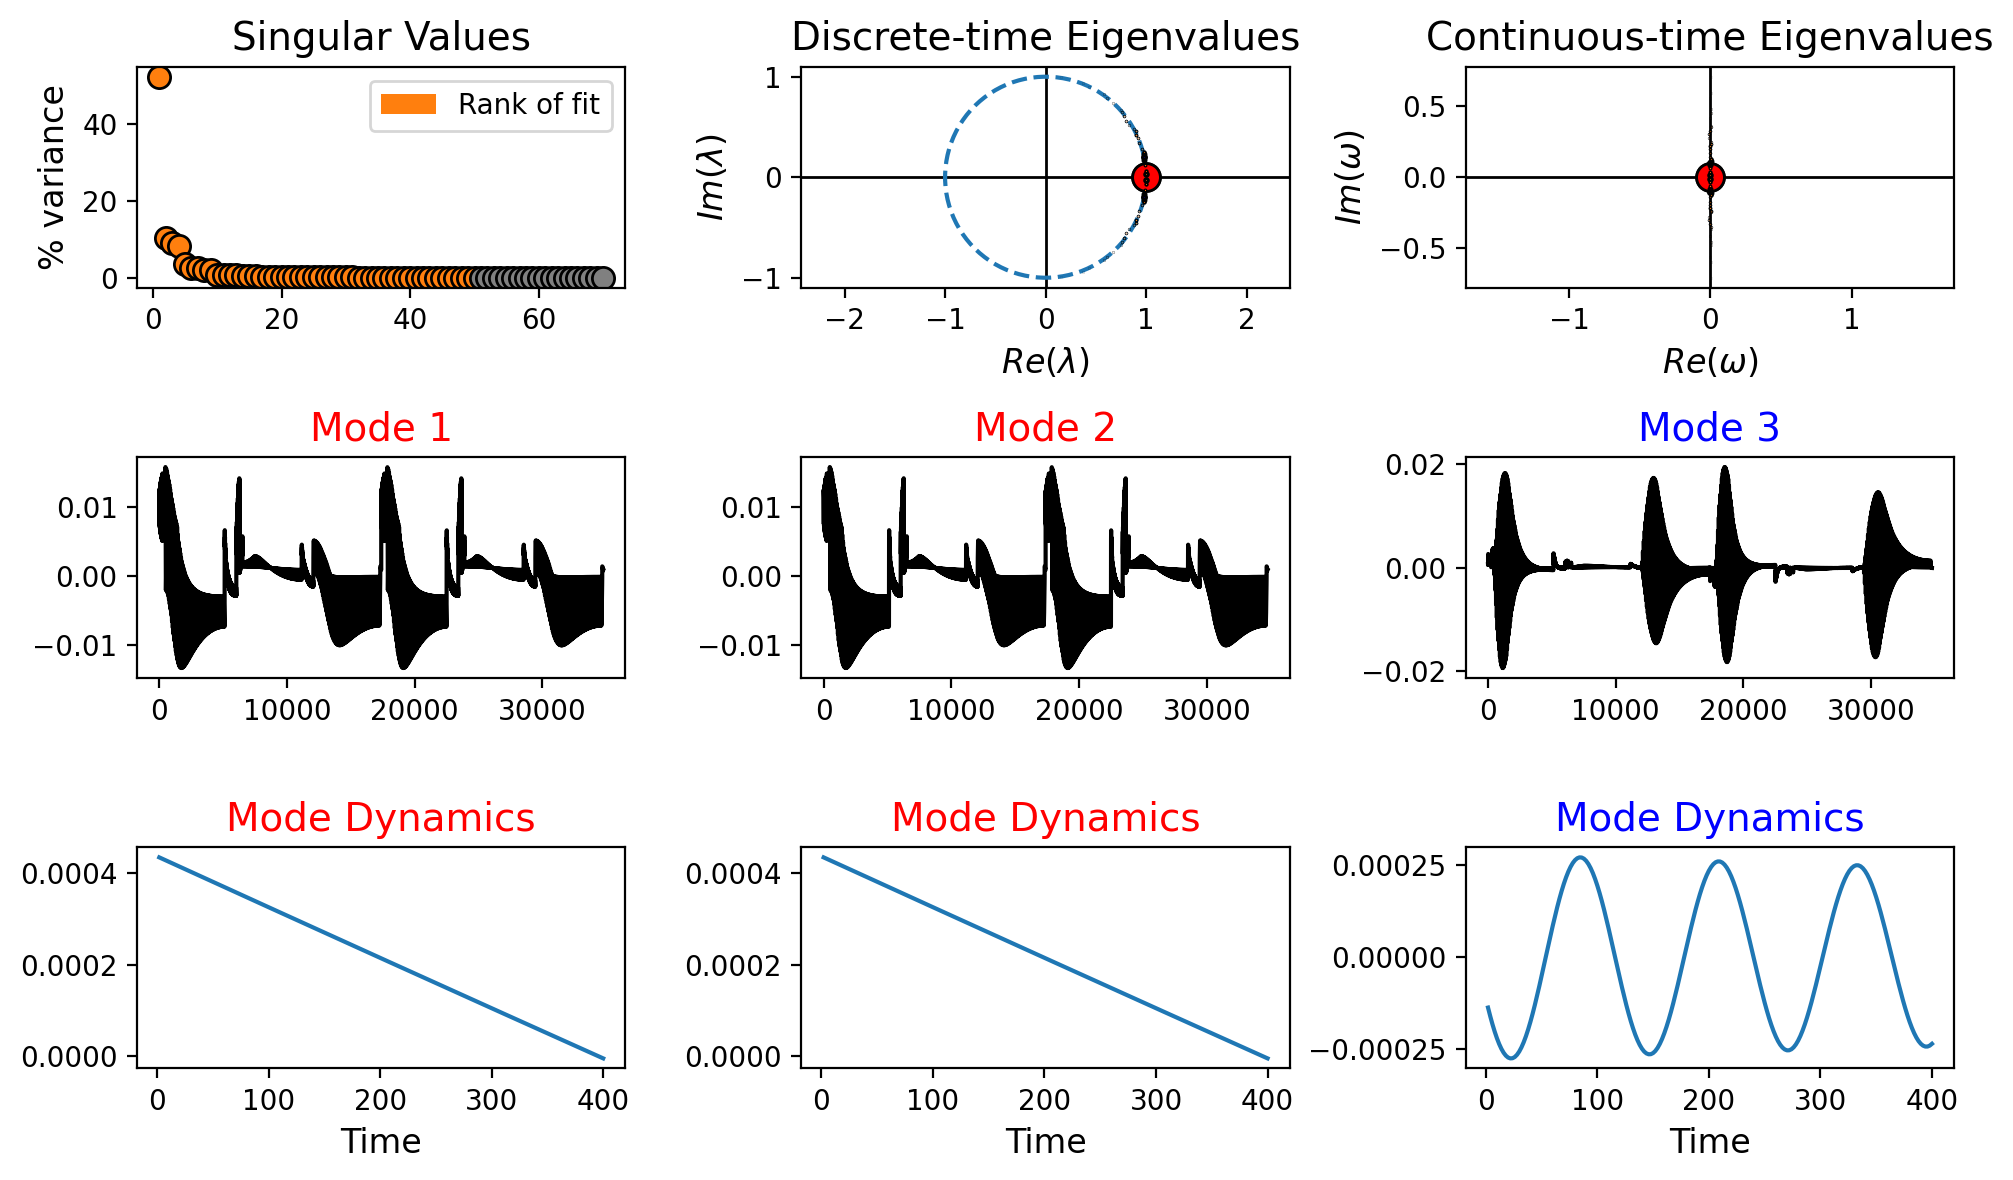

In [26]:
from pydmd.plotter import plot_summary

plot_summary(dmd_models[var_names[0]], figsize=(10,6), max_sval_plot = 70) 

Let us plot the modes

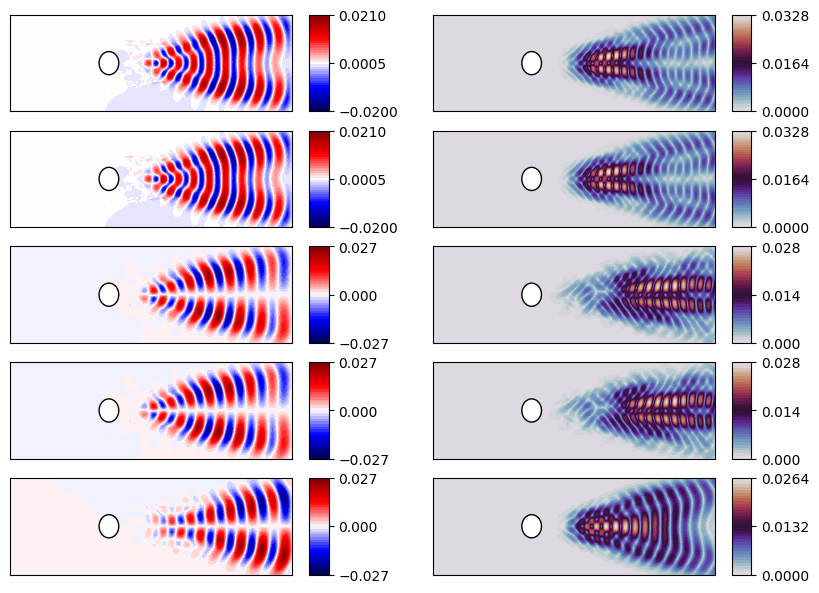

In [27]:
nrows = 5
ncols = len(var_names)

ylim = (-0.25, 0.25)
aspect_ratio = (ylim[1] - ylim[0]) / plotter.width

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows * aspect_ratio))

for field_i, field in enumerate(var_names):
    for rr in range(nrows):
        c = plotter.plot_contour(axes[rr, field_i], dmd_models[field].modes[:, rr].real,
                                 levels = 40, cmap=cmaps[field], ylim = ylim)
        cbar = fig.colorbar(c, ax=axes[rr, field_i], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

Let us predict future states using the trained DMD models and visualize the results.

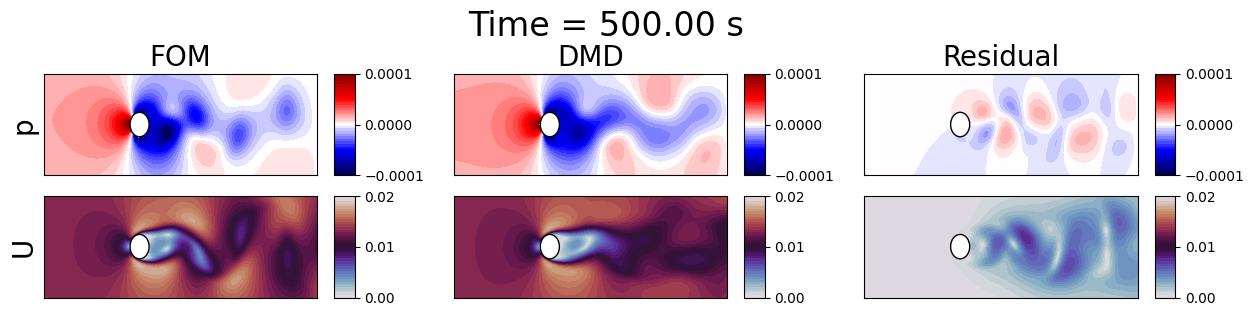

In [28]:
from IPython.display import clear_output as clc

nrows = len(var_names)
ncols = 3

ylim = (-0.25, 0.25)
aspect_ratio = (ylim[1] - ylim[0]) / plotter.width

levels = {
    'p': np.linspace(-1e-4, 1e-4, 40),
    'U': np.linspace(0, 0.02, 40)
}

for tt in range(train_cut+4, Nt, 5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows * aspect_ratio))

    for field_i, field in enumerate(var_names):

        dmd_models[field].dmd_time['t0']   = times[0]
        dmd_models[field].dmd_time['tend'] = times[tt]
        dmd_models[field].dmd_time['dt']   = times[1] - times[0]

        # Get the reconstructed snapshots
        recon = dmd_models[field].reconstructed_data.real[:, tt]

        # Original snapshot
        fom = dataset[field][tt]

        # Compute residual 
        # resid = np.abs(fom - recon)
        resid = fom - recon

        # Plot
        c = plotter.plot_contour(axes[field_i, 0], fom, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 0], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 1], recon, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 1], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 2], resid, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 2], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        axes[field_i, 0].set_ylabel(f'{field}', fontsize=20)

    axes[0, 0].set_title(f'FOM', fontsize=20)
    axes[0, 1].set_title(f'DMD', fontsize=20)
    axes[0, 2].set_title(f'Residual', fontsize=20)

    fig.suptitle(f'Time = {times[tt]:.2f} s', fontsize=24, y=1.1)

    plt.show()
    clc(wait=True)
    plt.close()

Let us plot some line profiles to compare the FOM and DMD results.

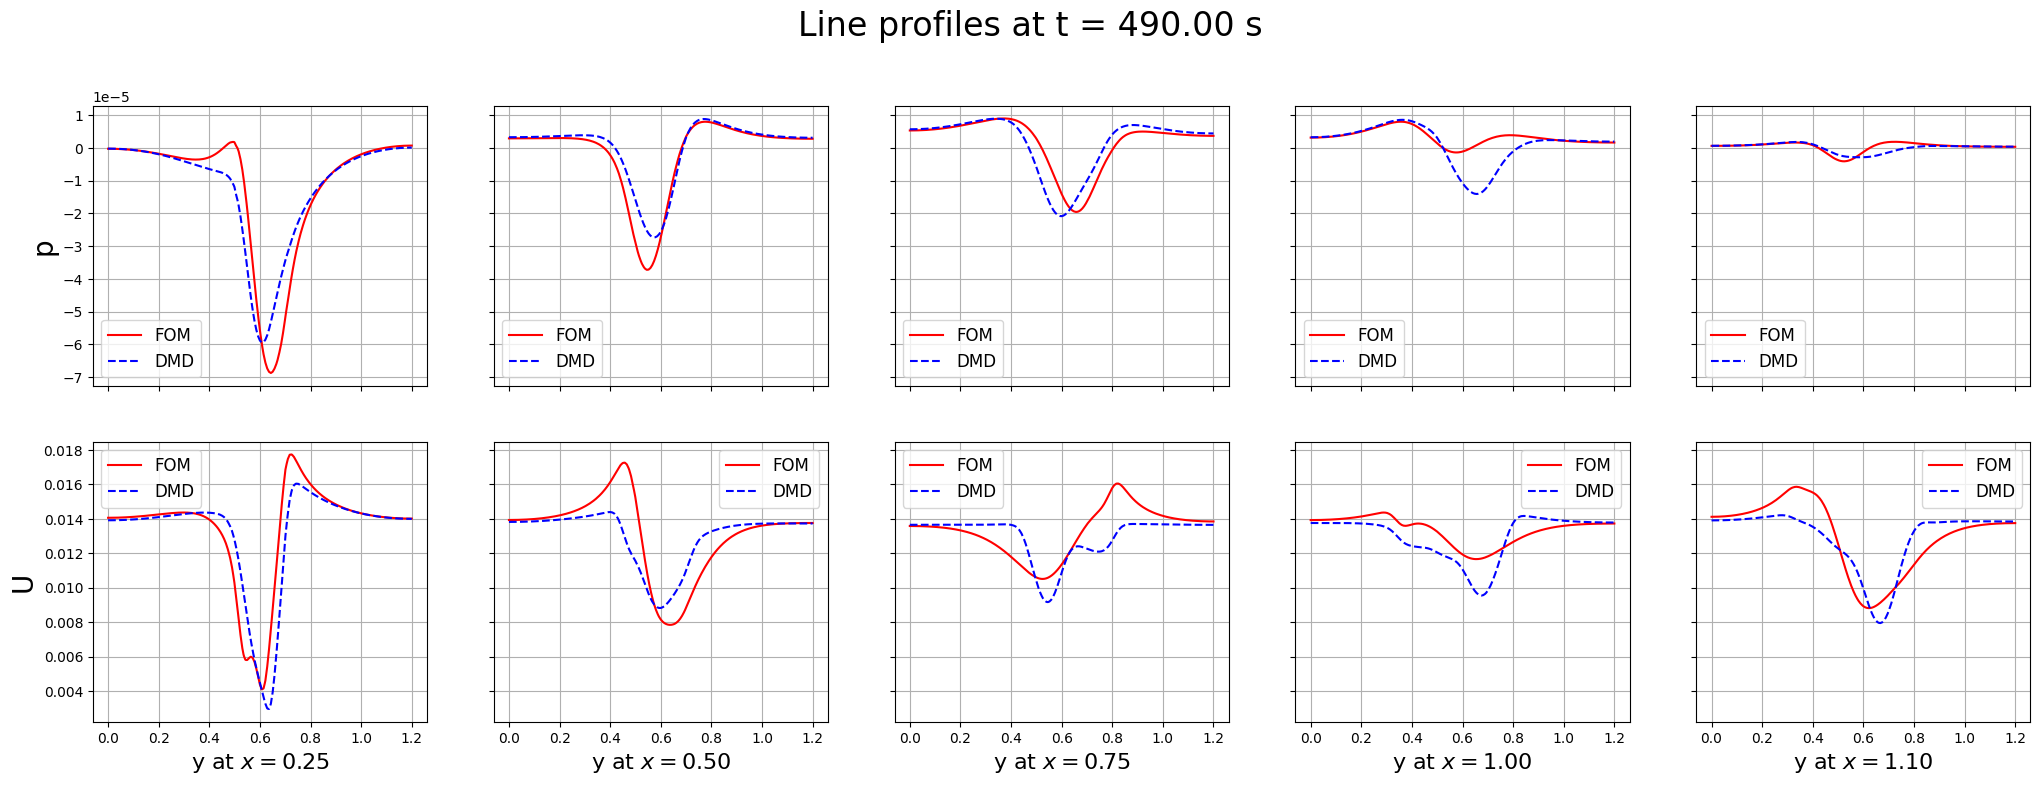

In [29]:
for tt in range(train_cut+4, Nt, 10):
    lines_x = [0.25, 0.5, 0.75, 1, 1.1]

    nrows = len(var_names)
    ncols = len(lines_x)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharey='row', sharex=True)

    for field_i, field in enumerate(var_names):
        for xx, _linex in enumerate(lines_x):

            grid.clear_data()
            grid['fom'] = np.linalg.norm(dataset[field][tt].reshape(-1, 3), axis=1) if field == 'U' else dataset[field][tt]
            grid['dmd'] = np.linalg.norm(dmd_models[field].reconstructed_data.real[:, tt].reshape(-1, 3), axis=1) if field == 'U' else dmd_models[field].reconstructed_data.real[:, tt]

            line_grid = grid.cell_data_to_point_data().sample_over_line(pointa = (_linex, -0.6, 0), pointb=(_linex, 0.6, 0), resolution=500)

            axs[field_i, xx].plot(line_grid['Distance'], line_grid['fom'], label='FOM', color='r')
            axs[field_i, xx].plot(line_grid['Distance'], line_grid['dmd'], label='DMD', color='b', linestyle='--')
            axs[field_i, xx].grid(True)
            axs[field_i, xx].legend(fontsize=12)

            if xx == 0:
                axs[field_i, xx].set_ylabel(f'{field}', fontsize=20)
            if field_i == nrows - 1:
                axs[field_i, xx].set_xlabel(f'y at $x = {_linex:.2f}$', fontsize=16)

    fig.suptitle(f'Line profiles at t = {times[tt]:.2f} s', fontsize=24, y=1.00)

    plt.show()
    clc(wait=True)
    plt.close()

Some discrepancies are observed between the FOM and DMD results, this is because the standard DMD is not able to entirely capture complex dynamics, unless a large number of modes is used. Let us measure the error in time between the FOM and DMD results.

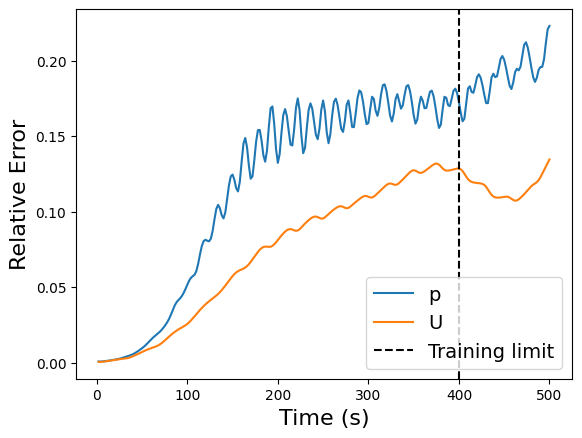

In [30]:
errors['DMD'] = np.zeros((len(var_names), Nt))

for ii, field in enumerate(var_names):

    fom = dataset[field].return_matrix()
    recon = dmd_models[field].reconstructed_data.real

    error = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
    errors['DMD'][ii] = error

    plt.plot(times, error, label=field)

plt.axvline(x=train_times[-1], color='k', linestyle='--', label='Training limit')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Relative Error', fontsize=16)
plt.legend(fontsize=14)

## Hankel DMD (HODMD) with *pyDMD*
The Higher-Order Dynamic Mode Decomposition (HODMD) is an extension of the standard DMD technique that aims to improve the accuracy and robustness of the decomposition by considering higher-order correlations in the data. HODMD is particularly useful for systems with complex dynamics, where standard DMD may struggle to capture the underlying behavior.

In [31]:
from pydmd import HODMD

hodmd_models = dict()

delay = 5

for field in var_names:
    
    print(f'Fitting HODMD model for field: {field}')
    
    X = train_snaps[field].return_matrix()  # Shape: (Nh, 0.8 * Nt)
    
    # Create and fit HODMD model
    hodmd_models[field] = HODMD(svd_rank=50, d=delay)
    hodmd_models[field].fit(X)

    # Define original times
    hodmd_models[field].original_time['t0']   = train_times[0]
    hodmd_models[field].original_time['tend'] = train_times[-1]+1e-12
    hodmd_models[field].original_time['dt']   = train_times[1] - train_times[0]

    # Define times
    hodmd_models[field].dmd_time['t0']   = times[0]
    hodmd_models[field].dmd_time['dt']   = times[1] - times[0]
    hodmd_models[field].dmd_time['tend'] = train_times[-1]

Fitting HODMD model for field: p


/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 6082271.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Fitting HODMD model for field: U


/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 110200768.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


Let us predict future states using the trained DMD models and visualize the results.

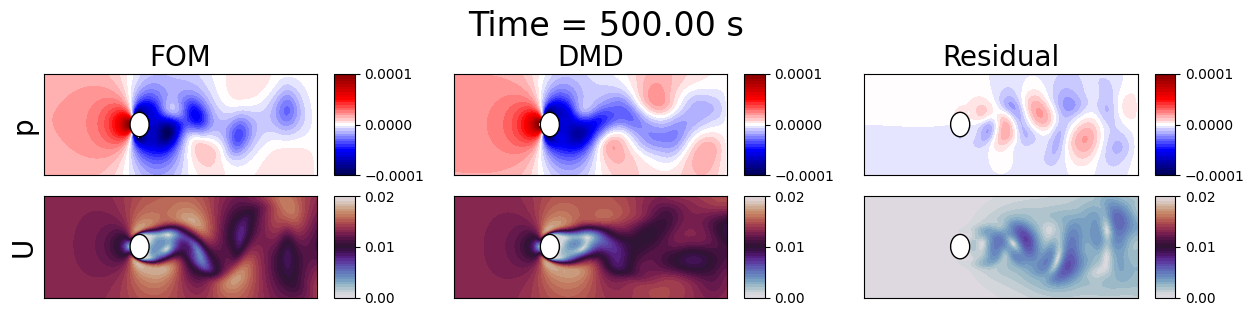

In [32]:
from IPython.display import clear_output as clc

nrows = len(var_names)
ncols = 3

ylim = (-0.25, 0.25)
aspect_ratio = (ylim[1] - ylim[0]) / plotter.width

levels = {
    'p': np.linspace(-1e-4, 1e-4, 40),
    'U': np.linspace(0, 0.02, 40)
}

for tt in range(train_cut+4, Nt, 5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows * aspect_ratio))

    for field_i, field in enumerate(var_names):

        hodmd_models[field].dmd_time['tend'] = times[-1] + 2 * (times[1] - times[0])

        # Get the reconstructed snapshots
        recon = hodmd_models[field].reconstructed_data.real[:, tt]

        # Original snapshot
        fom = dataset[field][tt]

        # Compute residual 
        # resid = np.abs(fom - recon)
        resid = fom - recon

        # Plot
        c = plotter.plot_contour(axes[field_i, 0], fom, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 0], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 1], recon, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 1], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 2], resid, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 2], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        axes[field_i, 0].set_ylabel(f'{field}', fontsize=20)

    axes[0, 0].set_title(f'FOM', fontsize=20)
    axes[0, 1].set_title(f'DMD', fontsize=20)
    axes[0, 2].set_title(f'Residual', fontsize=20)

    fig.suptitle(f'Time = {times[tt]:.2f} s', fontsize=24, y=1.1)

    plt.show()
    clc(wait=True)
    plt.close()

Let us plot the errors in time between the FOM and HODMD results, including the previous DMD results for comparison.

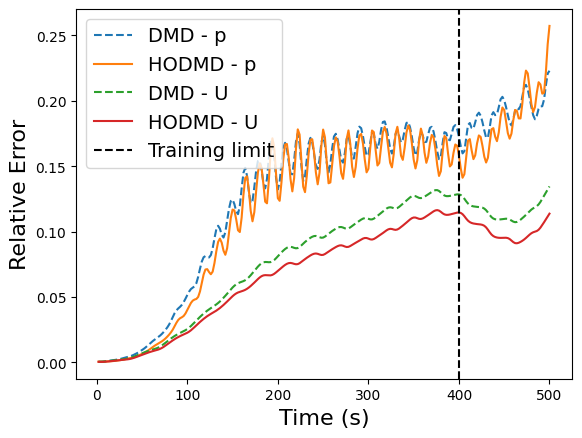

In [33]:
errors['HODMD'] = np.zeros((len(var_names), Nt))

for ii, field in enumerate(var_names):

    fom = dataset[field].return_matrix()
    recon = hodmd_models[field].reconstructed_data.real

    error = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
    errors['HODMD'][ii] = error

    plt.plot(times, errors['DMD'][ii], '--', label='DMD - ' + field)
    plt.plot(times, errors['HODMD'][ii], label='HODMD - ' + field)

plt.axvline(x=train_times[-1], color='k', linestyle='--', label='Training limit')
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Relative Error', fontsize=16)
plt.legend(fontsize=14)

## Bagging-Optimized DMD (BOPDMD) with *pyDMD*
The Bagging-Optimized Dynamic Mode Decomposition (BOPDMD) is an advanced variant of the DMD technique that computes the eigenvalues and modes through an optimization approach, including a bagging strategy to enhance robustness and accuracy with noisy data.

In [34]:
from pydmd import BOPDMD

bopdmd_models = dict()

for field in var_names:

    print(f'Fitting BOPDMD model for field: {field}')
    
    X = train_snaps[field].return_matrix()  # Shape: (Nh, 0.8 * Nt)
    
    # Create and fit BOPDMD model
    bopdmd_models[field] = BOPDMD(svd_rank = 30, eig_constraints={'stable', 'conjugate_pairs'})
    bopdmd_models[field].fit(X, train_times)

Fitting BOPDMD model for field: p


/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/pydmd/bopdmd.py:973: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Fitting BOPDMD model for field: U


Let us predict future states using the trained DMD models and visualize the results.

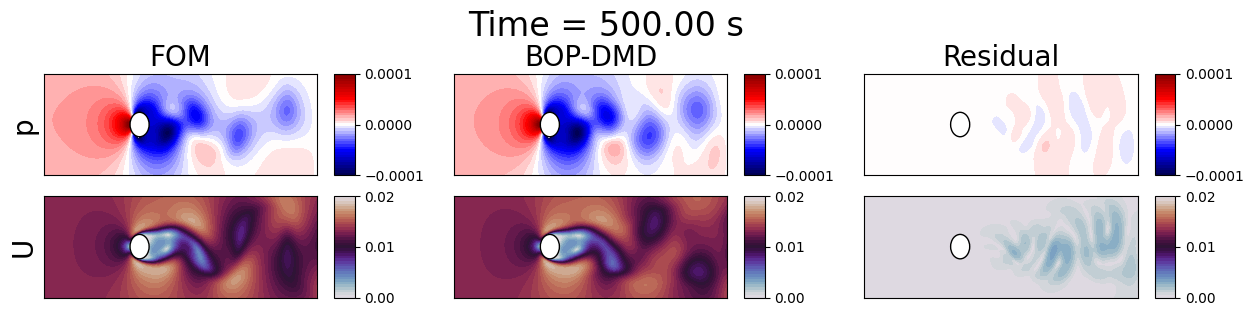

In [35]:
from IPython.display import clear_output as clc

nrows = len(var_names)
ncols = 3

ylim = (-0.25, 0.25)
aspect_ratio = (ylim[1] - ylim[0]) / plotter.width

levels = {
    'p': np.linspace(-1e-4, 1e-4, 40),
    'U': np.linspace(0, 0.02, 40)
}

for tt in range(train_cut+4, Nt, 5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows * aspect_ratio))

    for field_i, field in enumerate(var_names):

        # Get the reconstructed snapshots
        recon = bopdmd_models[field].forecast(times[tt]).real.flatten()

        # Original snapshot
        fom = dataset[field][tt]

        # Compute residual 
        # resid = np.abs(fom - recon)
        resid = fom - recon

        # Plot
        c = plotter.plot_contour(axes[field_i, 0], fom, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 0], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 1], recon, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 1], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        c = plotter.plot_contour(axes[field_i, 2], resid, cmap=cmaps[field], levels=levels[field], ylim=ylim)
        cbar = fig.colorbar(c, ax=axes[field_i, 2], aspect = 5)
        cbar.ax.set_yticks(np.linspace(c.get_clim()[0], c.get_clim()[1], num=3))

        axes[field_i, 0].set_ylabel(f'{field}', fontsize=20)

    axes[0, 0].set_title(f'FOM', fontsize=20)
    axes[0, 1].set_title(f'BOP-DMD', fontsize=20)
    axes[0, 2].set_title(f'Residual', fontsize=20)

    fig.suptitle(f'Time = {times[tt]:.2f} s', fontsize=24, y=1.1)

    plt.show()
    clc(wait=True)
    plt.close()

Let us compare the line profiles

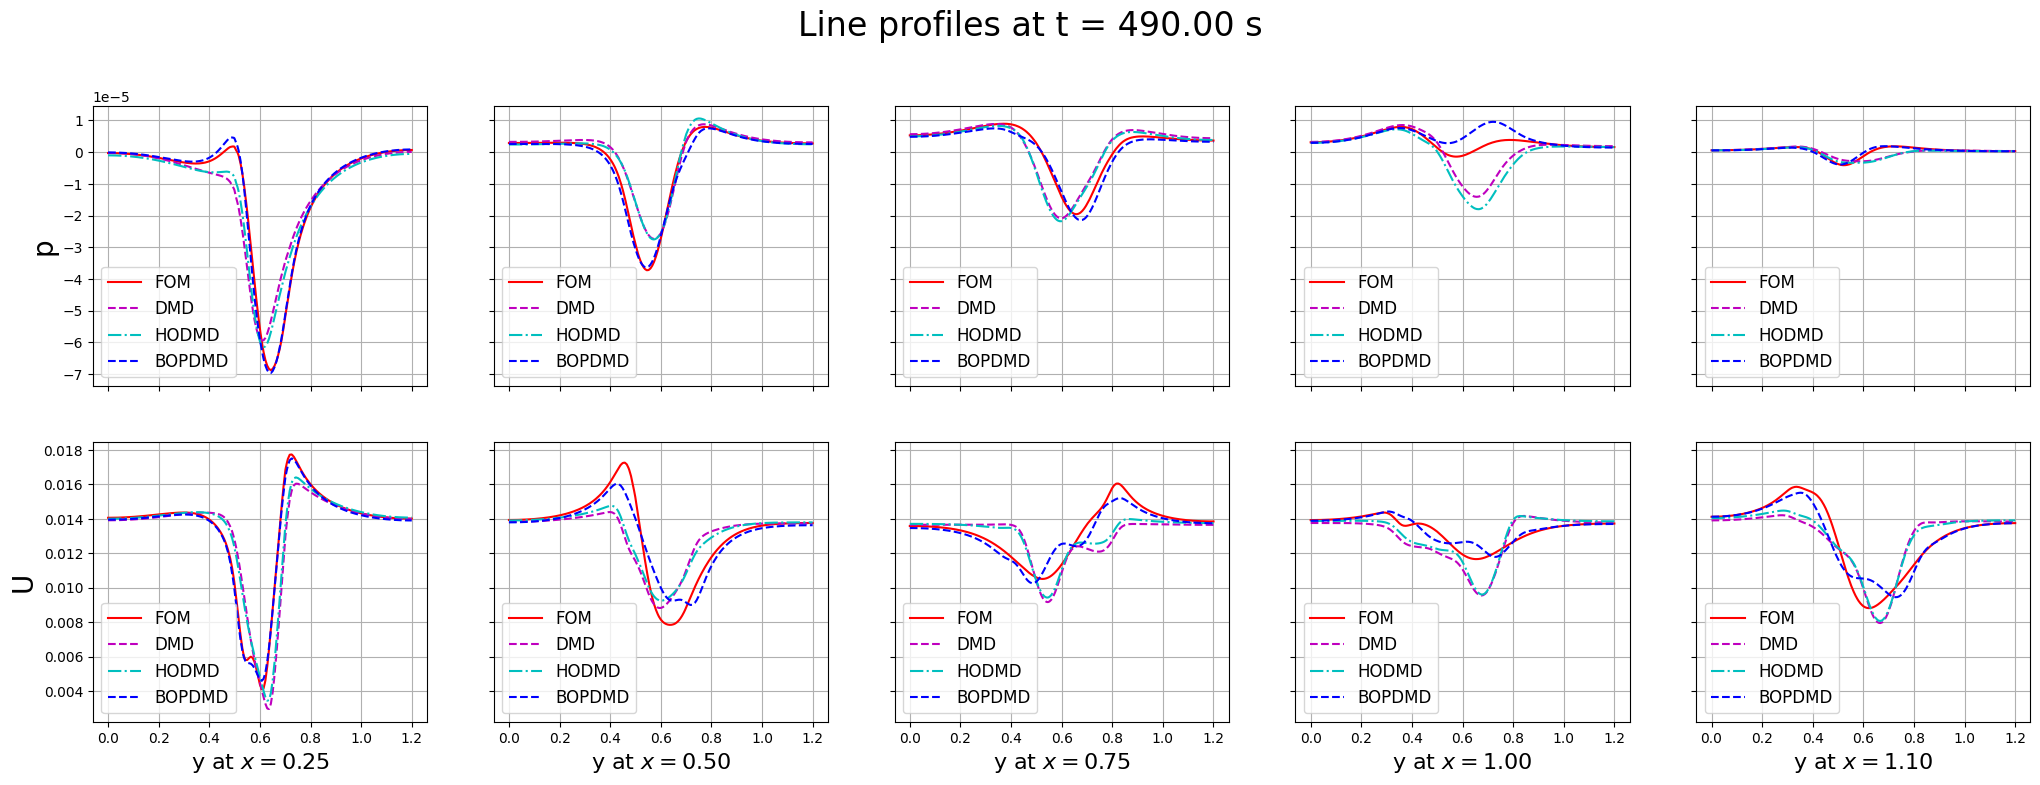

In [36]:
for tt in range(train_cut+4, Nt, 10):
    lines_x = [0.25, 0.5, 0.75, 1, 1.1]

    nrows = len(var_names)
    ncols = len(lines_x)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharey='row', sharex=True)

    for field_i, field in enumerate(var_names):
        for xx, _linex in enumerate(lines_x):

            grid.clear_data()
            grid['fom'] = np.linalg.norm(dataset[field][tt].reshape(-1, 3), axis=1) if field == 'U' else dataset[field][tt]
            grid['dmd'] = np.linalg.norm(dmd_models[field].reconstructed_data.real[:, tt].reshape(-1, 3), axis=1) if field == 'U' else dmd_models[field].reconstructed_data.real[:, tt]
            grid['hodmd'] = np.linalg.norm(hodmd_models[field].reconstructed_data.real[:, tt].reshape(-1, 3), axis=1) if field == 'U' else hodmd_models[field].reconstructed_data.real[:, tt]
            grid['bopdmd'] = np.linalg.norm(bopdmd_models[field].forecast(times).real[:, tt].reshape(-1, 3), axis=1) if field == 'U' else bopdmd_models[field].forecast(times).real[:, tt]

            line_grid = grid.cell_data_to_point_data().sample_over_line(pointa = (_linex, -0.6, 0), pointb=(_linex, 0.6, 0), resolution=500)

            axs[field_i, xx].plot(line_grid['Distance'], line_grid['fom'], label='FOM', color='r')
            axs[field_i, xx].plot(line_grid['Distance'], line_grid['dmd'], label='DMD', color='m', linestyle='--')
            axs[field_i, xx].plot(line_grid['Distance'], line_grid['hodmd'], label='HODMD', color='c', linestyle='-.')
            axs[field_i, xx].plot(line_grid['Distance'], line_grid['bopdmd'], label='BOPDMD', color='b', linestyle='--')
            axs[field_i, xx].grid(True)
            axs[field_i, xx].legend(fontsize=12)

            if xx == 0:
                axs[field_i, xx].set_ylabel(f'{field}', fontsize=20)
            if field_i == nrows - 1:
                axs[field_i, xx].set_xlabel(f'y at $x = {_linex:.2f}$', fontsize=16)

    fig.suptitle(f'Line profiles at t = {times[tt]:.2f} s', fontsize=24, y=1.00)

    plt.show()
    clc(wait=True)
    plt.close()

The reconstruction and prediction is much more accurate than the previous DMD techniques. Let us plot the errors in time between the FOM and BOPDMD results, including the previous DMD and HODMD results for comparison.

Text(0, 0.5, 'Relative Error')

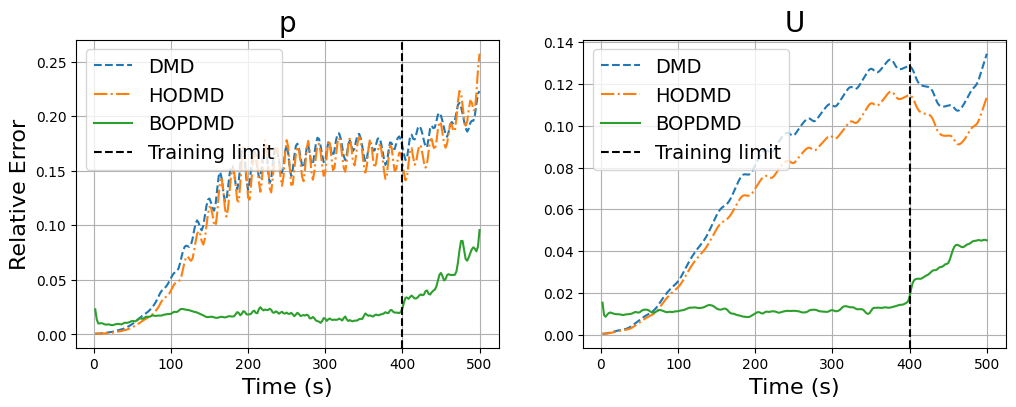

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

errors['BOPDMD'] = np.zeros((len(var_names), Nt))

for ii, field in enumerate(var_names):

    fom = dataset[field].return_matrix()
    recon = bopdmd_models[field].forecast(times).real

    error = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
    errors['BOPDMD'][ii] = error

    axs[ii].plot(times, errors['DMD'][ii], '--', label='DMD')
    axs[ii].plot(times, errors['HODMD'][ii], '-.', label='HODMD')
    axs[ii].plot(times, errors['BOPDMD'][ii], label='BOPDMD')

    axs[ii].axvline(x=train_times[-1], color='k', linestyle='--', label='Training limit')
    axs[ii].set_xlabel('Time (s)', fontsize=16)
    axs[ii].legend(fontsize=14)
    axs[ii].grid(True)
    axs[ii].set_title(f'{field}', fontsize=20)

axs[0].set_ylabel('Relative Error', fontsize=16)